# Data Exploration and Run Experiments Locally

### Objective

Make forecasts of NDVI (Normalized Difference Vegetation Index) from past time series data from EE. Along with past NDVI, additional regressors such as precipitation

**NOTE:** NDVI is typically used to determine the density of green on a patch of land. The values off NDVI range from -1 to +1 [Ref](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/).
- NDVI negative    --> highly likely it’s water
- NDVI close to +1 --> dense green leaves
- NDVI close to 0  --> No green leaves (maybe urbanized or dry lands)

In [22]:
# core
import datetime

# earth engine related
import ee
import geemap

# analysis
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# plotting related
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
import seaborn as sns

# google cloud
from google.cloud import bigquery as bq
from google.cloud import storage as gcs

In [2]:
ee.Initialize()

## Select and explore region of interest

In [3]:
Map = geemap.Map(center=[40,-100], zoom=4)

In [4]:
# Set start and end date
start_time = datetime.datetime(2015, 1, 1)
end_time = datetime.datetime(2019, 12, 31)

In [5]:
# Add Earth Engine dataset
# USDA NAIP ImageCollection
naip_collection = ee.ImageCollection('USDA/NAIP/DOQQ')

# create an roi
# e.g. Bakersfield, CA
polys = ee.Geometry.Polygon(
        [[[-119.233602, 35.293567], 
          [-119.234022, 35.15474], 
          [-118.999776, 35.154268], 
          [-119.042154, 35.294108], 
          [-119.233602, 35.293567]]])

# create a FeatureCollection based on the roi and center the map
centroid = polys.centroid()
lng, lat = centroid.getInfo()['coordinates']
print("lng = {}, lat = {}".format(lng, lat))
Map.setCenter(lng, lat, 12)
fc = ee.FeatureCollection(polys)

lng = -119.12690096102168, lat = 35.22187222632513


In [6]:
# filter the ImageCollection using the roi
naip = naip_collection.filterBounds(polys).filterDate(start_time, end_time)

# print out the number of images in the ImageCollection
count = naip.size().getInfo()
print("Count: ", count)

# add the ImageCollection and the roi to the map
vis = {'bands': ['N', 'R', 'G']}
Map.addLayer(naip)
Map.addLayer(fc)

Count:  26


In [7]:
Map

Map(center=[35.22187222632513, -119.12690096102168], controls=(WidgetControl(options=['position', 'transparent…

## Explore NDVI and precipitation data

- [PROBA-V C1 Top Of Canopy Daily Synthesis 100m](https://developers.google.com/earth-engine/datasets/catalog/VITO_PROBAV_C1_S1_TOC_100M) to map land cover and vegetation growth
- [USGS Landsat 8 Collection 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_RT?hl=en) to derive [NDVI](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index) from Red and Near Infrared bands
- [CHIRPS Pentad: Climate Hazards Group InfraRed Precipitation](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_PENTAD?hl=en)

### NDVI from Landsat 8 imagery

In [8]:
landsat8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate(start_time, end_time).select(['B5',u'B4'])

# retrieve info over region of interest with resolution of 500m
info_landsat8 = landsat8.getRegion(polys, 500).getInfo()

In [9]:
# sample data
info_landsat8[:2]

[['id', 'longitude', 'latitude', 'time', 'B5', 'B4'],
 ['LC08_041036_20150127',
  -119.2311418729738,
  35.157814432227774,
  1422383297340,
  7892,
  7397]]

In [32]:
def convert_to_pandas_df(info, band_list):
    """ convert region info as dataframe
    """
    header = info[0]
    data = np.array(info[1:])
    idx_time = header.index('time')
    time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,idx_time].astype(int))]

    bands = [header.index(b) for b in band_list]
    band_data = data[0:, bands]
    df = pd.DataFrame(data=band_data, index=time, columns=band_list).dropna()
    return df

In [74]:
df_landsat8 = convert_to_pandas_df(info_landsat8, ['B5','B4'])
df_landsat8[['B5','B4']] = df_landsat8[['B5','B4']].astype(np.float)

In [75]:
# calculate NDVI
# https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index
df_landsat8['ndvi'] = (df_landsat8['B5'] - df_landsat8['B4']) / (df_landsat8['B5'] + df_landsat8['B4'])

In [76]:
df_landsat8.head()

,B5,B4,ndvi
2015-01-27 18:28:17.340,7892.0,7397.0,0.032376
2015-02-28 18:28:06.520,10835.0,9487.0,0.066332
2015-03-16 18:27:55.590,16125.0,12835.0,0.113605
2015-04-01 18:27:44.040,14303.0,8713.0,0.242875
2015-04-17 18:27:43.020,20016.0,10138.0,0.327585


In [77]:
# time-series resampling to monthly
m_landsat_ndvi = df_landsat8[['ndvi']].resample('M').mean()

In [78]:
m_landsat_ndvi.head()

,ndvi
2015-01-31,0.117416
2015-02-28,0.211420
2015-03-31,0.268434
2015-04-30,0.225970
2015-05-31,0.230927


### NDVI from PROBAV imagery

In [53]:
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(start_time, end_time).select(['NDVI'])

# increasing resolution to 800 to avoid too many values error
#     ImageCollection.getRegion: Too many values: 1470 points x 1 bands x 1821 images > 1048576.
info_probav = probav.getRegion(polys, 800).getInfo()

In [54]:
len(info_probav)

1012477

In [55]:
df_probav = convert_to_pandas_df(info_probav, ['NDVI'])

In [79]:
df_probav.head()

,NDVI
2015-01-04,61
2015-01-08,59
2015-01-13,57
2015-01-17,26
2015-01-22,37


In [80]:
# time-series resampling to monthly
m_probav_ndvi = df_probav[['NDVI']].resample('M').mean()
m_probav_ndvi.head()

,NDVI
2015-01-31,85.028777
2015-02-28,136.938786
2015-03-31,134.156475
2015-04-30,123.315789
2015-05-31,89.493063


### Precipitation from CHIRPS imagery

In [81]:
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(start_time, end_time)

info_chirps = precipitation.getRegion(polys, 500).getInfo()

In [82]:
len(info_chirps)

527401

In [83]:
info_chirps[:2]

[['id', 'longitude', 'latitude', 'time', 'precipitation'],
 ['20150101',
  -119.2311418729738,
  35.157814432227774,
  1420070400000,
  0.5979218482971191]]

In [84]:
df_prcptn = convert_to_pandas_df(info_chirps, ['precipitation'])
df_prcptn['precipitation'] = df_prcptn['precipitation'].astype(np.float)

df_prcptn.head()

,precipitation
2015-01-01,0.597922
2015-01-06,0.676069
2015-01-11,8.741220
2015-01-16,2.124831
2015-01-21,0.839010


In [92]:
# time-series resampling to monthly
m_prcptn = df_prcptn[['precipitation']].resample('M').mean()
m_prcptn.head()

,precipitation
2015-01-31,5.645263
2015-02-28,3.489468
2015-03-31,3.336113
2015-04-30,1.498981
2015-05-31,0.776080


Text(0.5, 1.0, 'Probav NDVI')

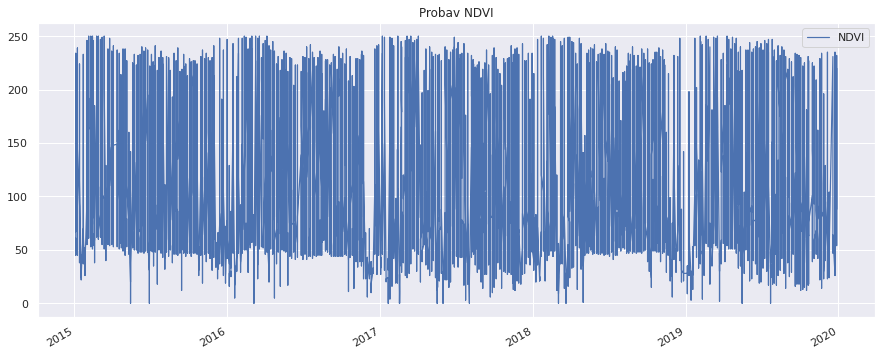

In [90]:
sns.set(rc={'figure.figsize':(15, 6)})
df_probav.plot(linewidth=1.2)
plt.title('Probav NDVI')

Text(0.5, 1.0, 'Monthly')

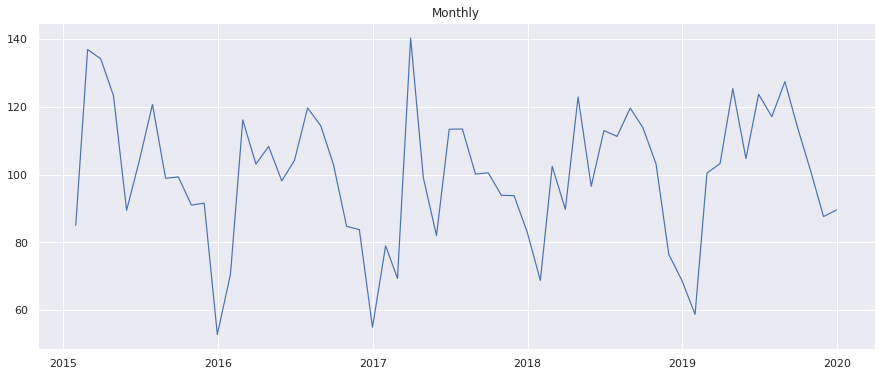

In [91]:
plt.plot(m_probav_ndvi['NDVI'], linewidth=1.2)
plt.title('Monthly')

## Combine data

In [98]:
monthly = pd.DataFrame({'landsat_ndvi': m_landsat_ndvi['ndvi'],
                        'chirps_prcptn': m_prcptn['precipitation'],
                        'probav_ndvi': m_probav_ndvi['NDVI']
                       },
                       index = m_prcptn.index)

In [97]:
monthly.head()

,landsat_ndvi,chirps_prcptn,probav_ndvi
2015-01-31,0.117416,5.645263,85.028777
2015-02-28,0.211420,3.489468,136.938786
2015-03-31,0.268434,3.336113,134.156475
2015-04-30,0.225970,1.498981,123.315789
2015-05-31,0.230927,0.776080,89.493063
